In [1]:
# 1. https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9

# 2. https://towardsdatascience.com/transfer-learning-and-image-classification-using-keras-on-kaggle-kernels-c76d3b030649

# 3. https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8

# 4.https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/

In [2]:
import numpy as np
from PIL import Image
import pytesseract
import cv2
from pytesseract import Output
import pandas as pd
import math
import re
import os
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
## Convert pdf to img :

from pdf2image.exceptions import (PDFInfoNotInstalledError, PDFPageCountError, PDFSyntaxError)

from pdf2image import convert_from_path, convert_from_bytes

images = convert_from_path('INVOICE3.pdf', dpi = 300, single_file = True) ## 300 is dpi

for page in images:
    
    page.save('INVOICE3.jpg', 'JPEG')

In [4]:
pwd

'/home/scar3crow/Dropbox/WorkStation-Subrata/python'

In [5]:
test_directory = '/home/scar3crow/Downloads/invoices'  ## 'invoices' is a zip file of jpg images in ...../Downloads 
                                                        
test_image_all = ['/home/scar3crow/Downloads/invoices/{}'.format(i) for i in os.listdir(test_directory)]
len(test_image_all)

4

In [6]:
print(type(test_image_all))
test_image_all[0]

<class 'list'>


'/home/scar3crow/Downloads/invoices/INVOICE1.jpg'

<function matplotlib.pyplot.show(*args, **kw)>

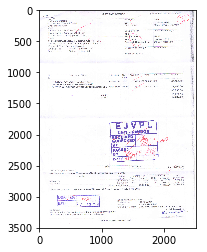

In [7]:
img = mpimg.imread(test_image_all[0])
imgplot = plt.imshow(img)
plt.show

In [8]:
## Loading images downloaded from Kaggle as 'train.zip'

train_dir = '/home/scar3crow/Downloads/train'

train_dogs = ['/home/scar3crow/Downloads/train/{}'.format(i) for i in os.listdir(train_dir) if 'dog' in i]
train_cats = ['/home/scar3crow/Downloads/train/{}'.format(i) for i in os.listdir(train_dir) if 'cat' in i]

train_images = train_dogs[:500] + train_cats[:500]  ## Slice dataset and use 2000 in each class i.e. dog & cat

random.shuffle(train_images)  ## random shuffle of the images

<function matplotlib.pyplot.show(*args, **kw)>

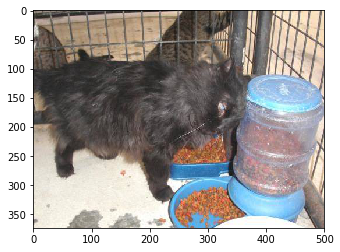

In [9]:
img = mpimg.imread(train_images[0])
imgplot = plt.imshow(img)
plt.show

In [10]:
train_images[0]

'/home/scar3crow/Downloads/train/cat.96.jpg'

In [11]:
## Now let us resize the images to one single size. For resizing : 1st dim is width(column) & nd dim is height(row)

# For cat/dog images:
nrows = 150
ncolumns = 150
channels = 3 ## for only color images

# For my invoices - be careful between rows & columns :
nrows_1 = 2200  
ncolumns_1 = 3000

# For cat/dog images where labels i.e. 'y' is to be created and learning will be done in colour :

def read_and_process_image(list_of_images):
    X = []  # images for training
    y = []  # labels for training
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC ))
        
        if 'dog' in image:
            y.append(1)
        if 'cat' in image:
            y.append(0)
    return X, y

# For my invoice images where labels i.e. 'y' is not to be created now and learning will be done in b/w :

def read_and_process_image_invoice(list_of_images):
    X_invoice = []  # images for training
    
    for image in list_of_images:
        X_invoice.append(cv2.resize(cv2.imread(image, 0), (nrows_1, ncolumns_1), interpolation = cv2.INTER_CUBIC ))
        
    return X_invoice


In [12]:
## Actual resizing and creating training images and labels :

X, y = read_and_process_image(train_images)

X_invoice = read_and_process_image_invoice(test_image_all)


In [13]:
print(type(X_invoice))
print(type(X_invoice[0]))

X_invoice[0].shape

<class 'list'>
<class 'numpy.ndarray'>


(3000, 2200)

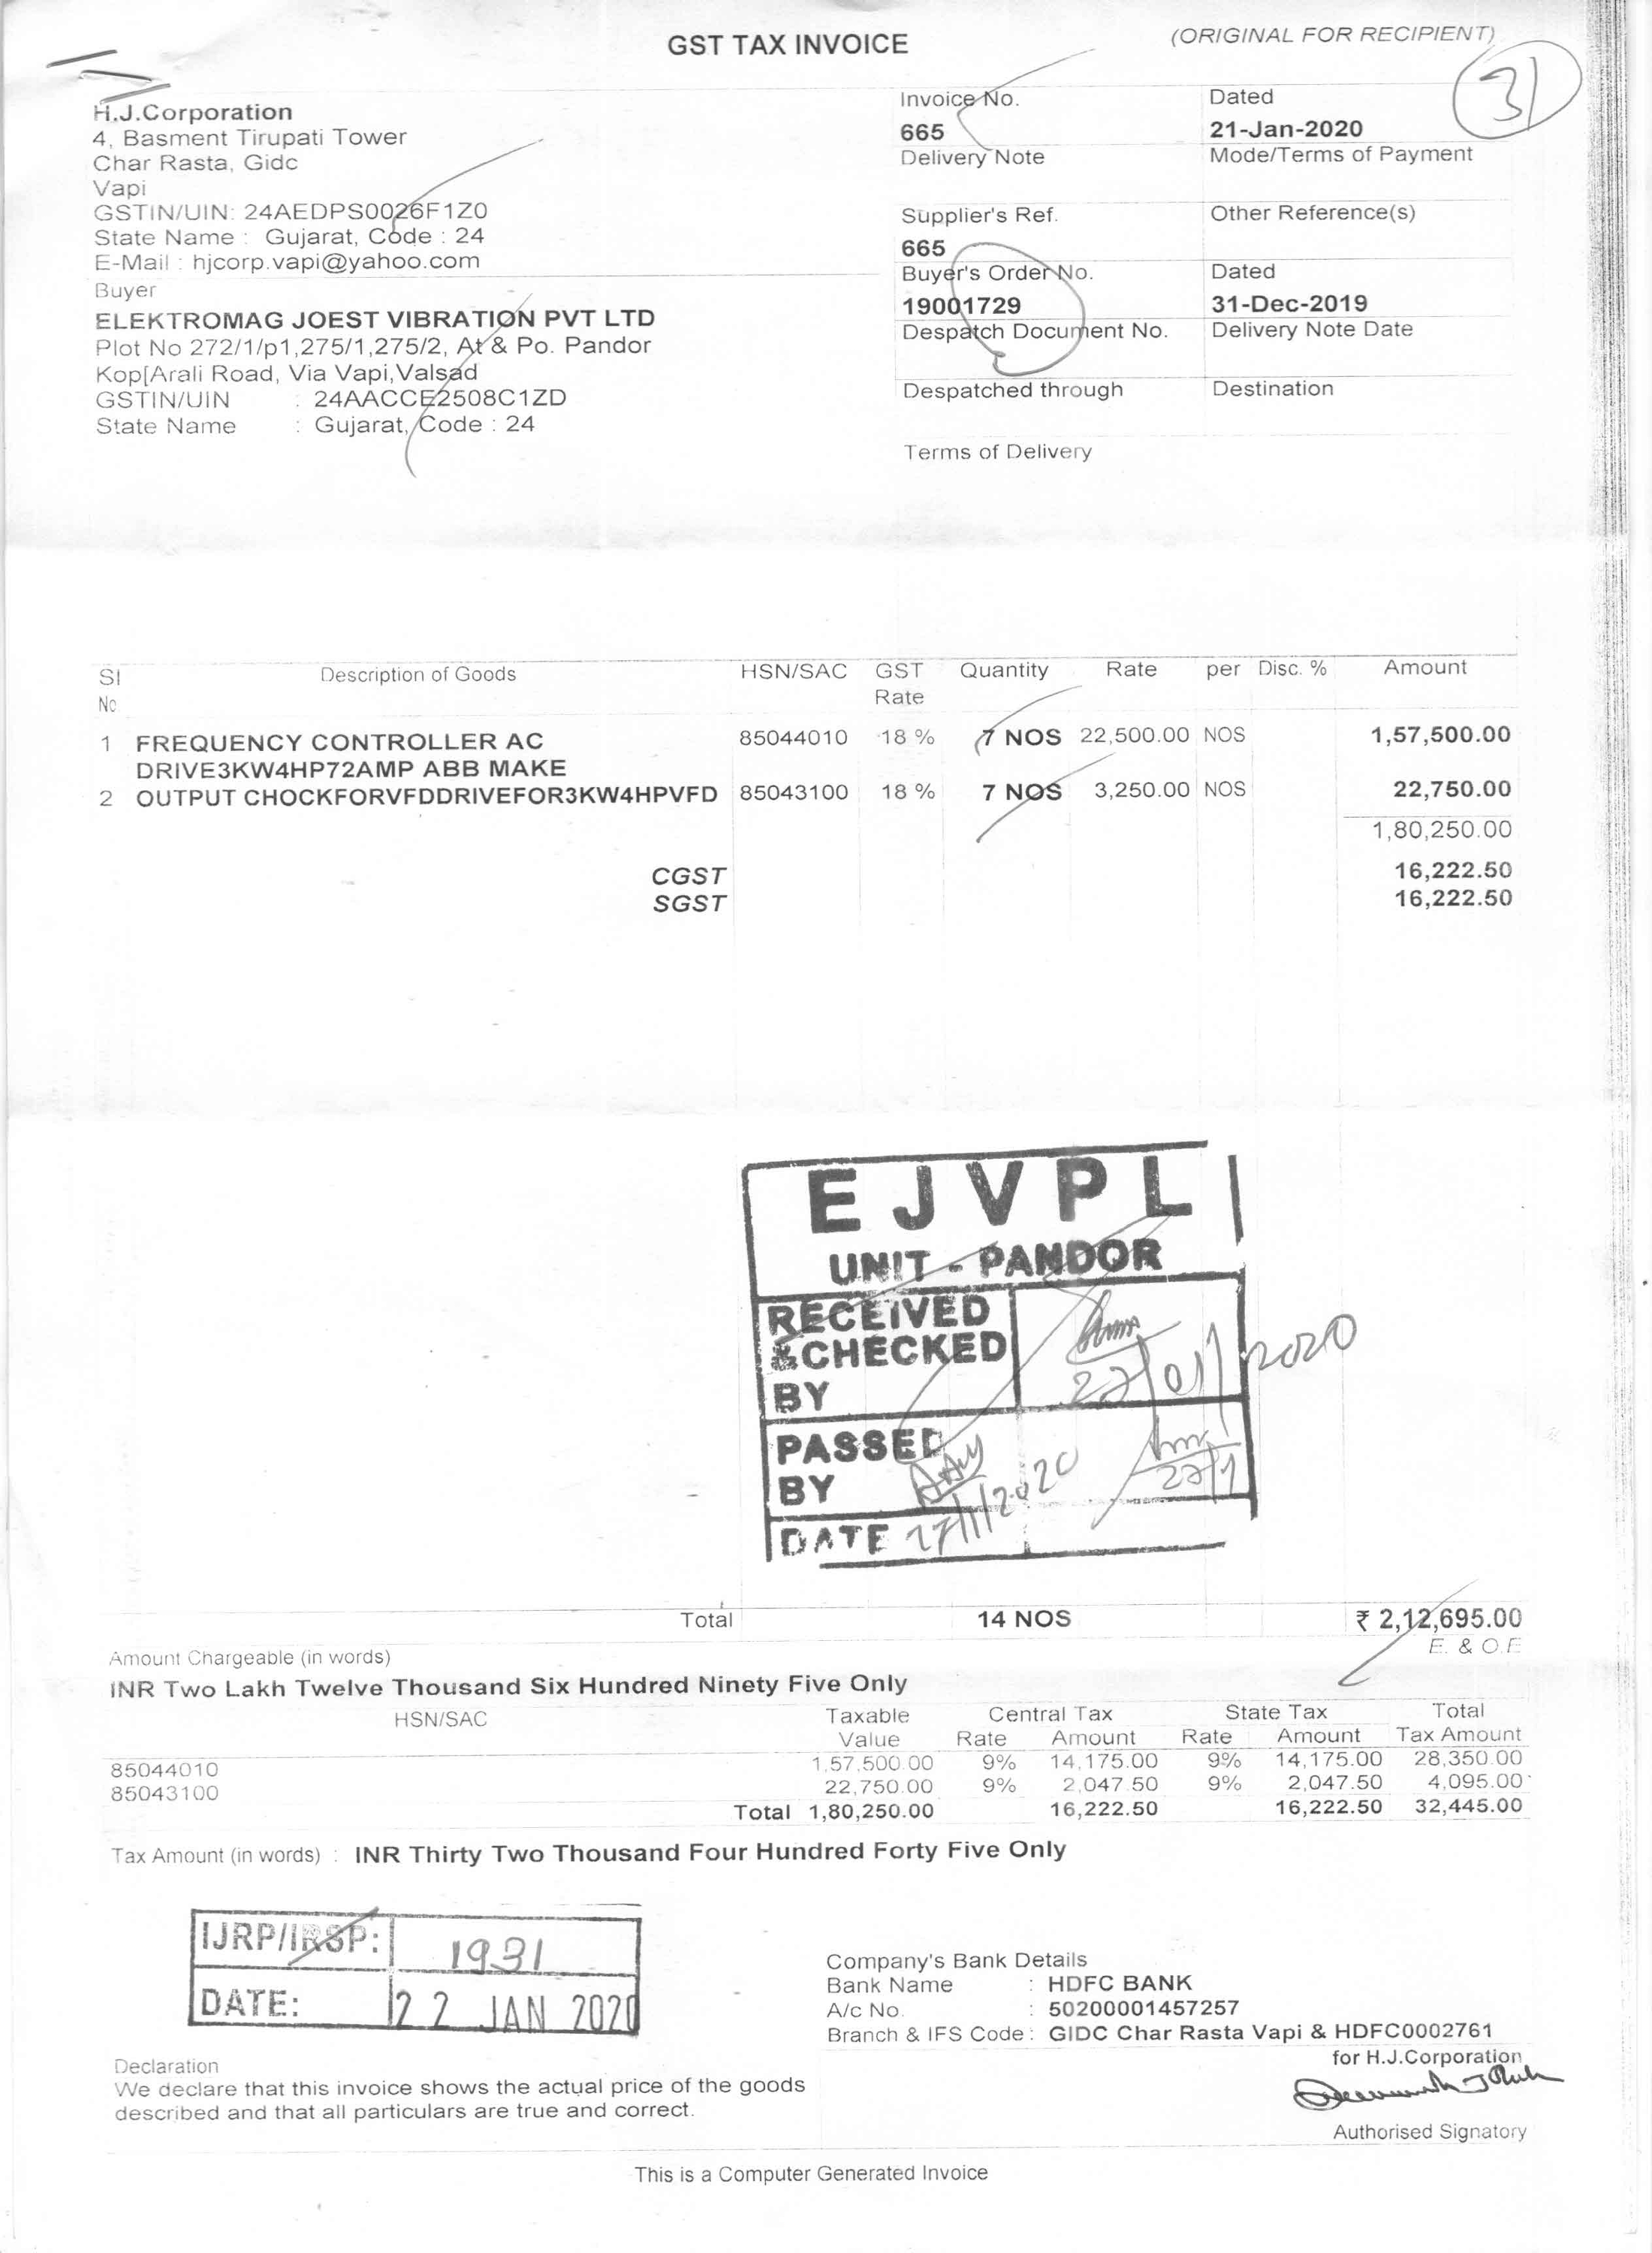

In [14]:
X_invoice_0_pil = Image.fromarray(X_invoice[0])
display(X_invoice_0_pil)

In [15]:
## Convert X and y into numpy array :

X = np.array(X)
y = np.array(y)
X_invoice = np.array(X_invoice)
print(X.shape)
print(y.shape)
print(X_invoice.shape)

(1000, 150, 150, 3)
(1000,)
(4, 3000, 2200)


In [16]:
## Lets Split the data in train and test set :

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 2)

print(X_train.shape)
print(type(X_train))
print(y_train.shape)
print(type(y_train))

## length of train and val data i.e. no. of training samples :

ntrain = len(X_train)
nval = len(X_val)

print(ntrain)


(800, 150, 150, 3)
<class 'numpy.ndarray'>
(800,)
<class 'numpy.ndarray'>
800


In [17]:
batch_size = 32

In [19]:
## Here, we tell keras to download the model’s pretrained weights and save it in the variable conv_base

from keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

219062272/219055592 [==============================] - 159s 1us/step


# include_top [False]: This tells Keras not to download the fully connected layers of the pretrained model. This is because the top layer (fully connected layers) does the final classification.
I.e After the convolution layers extract basic features such as edges, blobs or lines from the input images, the fully connected layer then classifies them into categories.
Since all we need is 2 class (dogs and cats) classifier, we are going to remove the former and add our own.

In [20]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
## Next, we create our fully connected layers (classifier) which we add on-top of the model we downloaded

In [24]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3539200   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 57,876,193
Trainable params: 57,815,649
Non-trainable params: 60,544
_________________________________________________________________


In [23]:
# Now we’re going freeze the conv_base and train only our own

# We print the number of weights in the model before freezing the conv_base 
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))

# we set the trainable property of the conv_base layer to False (we don’t want to train you)
conv_base.trainable = False

# Print the number of weights after freezing the conv_base
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 492
Number of trainable weights after freezing the conv base: 4


In [25]:
#We'll use the RMSprop optimizer with a learning rate of 0.0002
#We'll use binary_crossentropy loss because its a binary classification

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [26]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [27]:
#Create the image generators
train_generator = train_datagen.flow(X_train, y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [28]:
#The training part
#We train for 0 epochs - see the url for reasson to reduce epochs 64to 20
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=20,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Epoch 1/20
25/25 [==============================] - 161s 6s/step - loss: 0.6132 - acc: 0.6300 - val_loss: 0.2309 - val_acc: 0.9350
Epoch 2/20
25/25 [==============================] - 153s 6s/step - loss: 0.5358 - acc: 0.7288 - val_loss: 0.3040 - val_acc: 0.8950
Epoch 3/20
25/25 [==============================] - 152s 6s/step - loss: 0.4794 - acc: 0.7538 - val_loss: 0.2127 - val_acc: 0.9450
Epoch 4/20
25/25 [==============================] - 150s 6s/step - loss: 0.4494 - acc: 0.7800 - val_loss: 0.2087 - val_acc: 0.9550
Epoch 5/20
25/25 [==============================] - 163s 7s/step - loss: 0.4316 - acc: 0.8100 - val_loss: 0.2057 - val_acc: 0.9550
Epoch 6/20
25/25 [==============================] - 156s 6s/step - loss: 0.4149 - acc: 0.7900 - val_loss: 0.2664 - val_acc: 0.9350
Epoch 7/20
25/25 [==============================] - 159s 6s/step - loss: 0.3911 - acc: 0.8188 - val_loss: 0.2891 - val_acc: 0.9350
Epoch 8/20
25/25 [==============================] - 155s 6s/step - loss: 0.3650 - a

In [30]:
#Now lets predict on the first 3 Images of the test set

test_dir = '/home/scar3crow/Downloads/test'
test_imgs = ['/home/scar3crow/Downloads/test/{}'.format(i) for i in os.listdir(test_dir)] #get test images

X_test, y_test = read_and_process_image(test_imgs[0:3]) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

In [37]:
plt.figure(figsize=(30,20))

aaa = test_datagen.flow(x)

pred = model.predict(aaa[0])


<Figure size 2160x1440 with 0 Axes>

cat


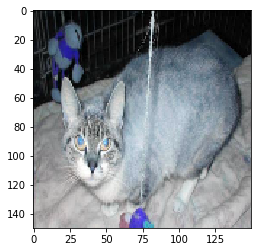

In [38]:
if pred[0] > 0.5:
    print('dog')
else:
    print('cat')
    
imgplot = plt.imshow(aaa[0][0])
plt.show()


cat


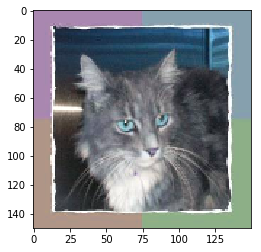

In [34]:
if pred[1] > 0.5:
    print('dog')
else:
    print('cat')
    
imgplot = plt.imshow(aaa[0][1])
plt.show()


dog


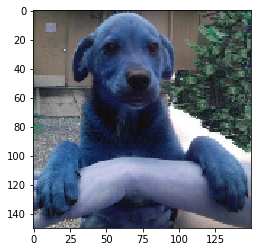

In [35]:
if pred[2] > 0.5:
    print('dog')
else:
    print('cat')
    
imgplot = plt.imshow(aaa[0][2])
plt.show()
